In [195]:
# import libraries
import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import sklearn
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt

# Get data
diabetes = pd.read_csv("http://storage.googleapis.com/optum-datasets-11/diabetes.csv")
diabetes = diabetes.reindex(
    np.random.permutation(diabetes.index)
)

# split data
n = len(diabetes.index)
train = diabetes
# train = diabetes.head(math.floor(0.8*n))
# test = diabetes.tail(math.floor(0.2*n))

In [169]:
train.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.132771,0.166434,-0.063112,-0.075178,0.019550,-0.039076,0.535132,0.231939
Glucose,0.132771,1.000000,0.141229,0.068612,0.307093,0.228240,0.135681,0.255856,0.473554
BloodPressure,0.166434,0.141229,1.000000,0.205788,0.088183,0.274510,0.038061,0.243013,0.089852
SkinThickness,-0.063112,0.068612,0.205788,1.000000,0.439611,0.379290,0.174318,-0.123035,0.081508
Insulin,-0.075178,0.307093,0.088183,0.439611,1.000000,0.202020,0.199153,-0.092440,0.115809
BMI,0.019550,0.228240,0.274510,0.379290,0.202020,1.000000,0.120712,0.042115,0.276877
DiabetesPedigreeFunction,-0.039076,0.135681,0.038061,0.174318,0.199153,0.120712,1.000000,0.012335,0.140595
Age,0.535132,0.255856,0.243013,-0.123035,-0.092440,0.042115,0.012335,1.000000,0.235159
Outcome,0.231939,0.473554,0.089852,0.081508,0.115809,0.276877,0.140595,0.235159,1.000000


# Essential Functions

### Input Functions

In [196]:
def eval_input_fn(features, labels=None, batch_size=1):
    """An input function for prediction"""
    features= dict(features)
    if labels is None:
        # No labels, use only features.
        inputs = features
    else:
        inputs = (features, labels)
    # convert inputs to DataSet
    dataset = tf.data.Dataset.from_tensor_slices(inputs)
    # shuffle, repeat, and batch examples
    return dataset.repeat(1).batch(batch_size)

def my_input_fn(features, targets=None, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural network model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = dict(features)
    if targets is None:
        inputs = features
    else:
        inputs = (features, targets)

    # Construct a dataset, and configure batching/repeating.
    ds = tf.data.Dataset.from_tensor_slices(inputs) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
        ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

### Features

In [197]:
def process_features(df):
    def linear_scale(series):
        min_val = series.min()
        max_val = series.max()
        scale = (max_val - min_val) / 2.0
        return series.apply(lambda x:((x - min_val) / scale) - 1.0)
    
    x = pd.DataFrame(df, columns=['Glucose', 'Age', 'Pregnancies', 'BMI'])
    return x

def process_targets(df):
    return pd.DataFrame(df, columns=['Outcome'])

def construct_feature_columns(input_features):
    return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])

In [198]:
train_x = process_features(train)
train_y = process_targets(train)
# test_x = process_features(test)
# test_y = process_targets(test)

### Instantiate Estimator

In [225]:
def train_dnn_classifier(
    steps,
    batch_size,
    hidden_units,
    train_x,
    train_y,
    validate_x=None,
    validate_y=None,
    validate=False,
    dropout=0):
    '''Trains neural network regression model'''
    
    periods = 10
    steps_per_period = steps / periods
    
    # Create DNN classifier object
#     my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0005)
    my_optimizer = tf.train.AdamOptimizer(learning_rate=0.00012)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    classifier = tf.estimator.DNNClassifier(
        feature_columns = construct_feature_columns(train_x),
        hidden_units = hidden_units,
        optimizer = my_optimizer,
        dropout = dropout
    )
    
    # Create input functions
    train_input_fn = lambda: my_input_fn(train_x, train_y, batch_size)
    predict_train_input_fn = lambda: my_input_fn(train_x, train_y, num_epochs=1, shuffle=False)
    predict_validate_input_fn = lambda: my_input_fn(validate_x, validate_y, num_epochs=1, shuffle=False)
    
    # Train model in loop to periodically assess
    print("Training model...")
    print("LogLoss error (on train/validation data):")
    training_log_losses = []
    validation_log_losses = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        classifier.train(
            input_fn=train_input_fn,
            steps=steps_per_period
        )

        # Take a break and compute probabilities.
        training_probabilities = classifier.predict(input_fn=predict_train_input_fn)
        training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
        training_log_loss = metrics.log_loss(train_y, training_probabilities)
        training_log_losses.append(training_log_loss)
        print("  train period %02d : %0.3f" % (period, training_log_loss))
        
        if validate:
            validation_probabilities = classifier.predict(input_fn=predict_validate_input_fn)
            validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
            validation_log_loss = metrics.log_loss(validate_y, validation_probabilities)
            validation_log_losses.append(validation_log_loss)
            print("  validation period %02d : %0.3f" % (period, validation_log_loss))
    print("Model training finished.")
    
    # Output a graph of loss metrics over periods.
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.tight_layout()
    plt.plot(training_log_losses, label="training")
    plt.plot(validation_log_losses, label="validation")
    plt.legend()

    return classifier

### Make classifier

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/sw/g_y6fnr14wj2y5y_d6bvyswd7jxbrs/T/tmprgaxpzu1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x14239cd68>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Training model...
LogLoss error (on train/validation data):
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
IN

INFO:tensorflow:Loss for final step: 24.685602.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/sw/g_y6fnr14wj2y5y_d6bvyswd7jxbrs/T/tmprgaxpzu1/model.ckpt-1400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
  train period 06 : 0.557
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/sw/g_y6fnr14wj2y5y_d6bvyswd7jxbrs/T/tmprgaxpzu1/model.ckpt-1400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1401 into /var/folders/sw/g_y6fnr14wj2y5y_d6bvyswd7jxbrs/T/tmprgaxpzu1/model.ckpt.
INFO:tensorflow:loss = 26.276632, step = 1401
INFO:tensorflow:global_step/sec: 427.115
INFO:tensorflow:loss = 25.110523, step = 1501 (0.

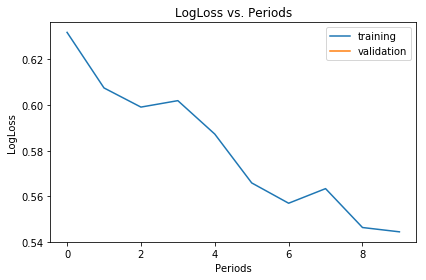

In [229]:
classifier = train_dnn_classifier(
        steps=2000,
        batch_size=50,
        hidden_units=[100, 75, 50, 25],
        train_x=train_x,
        train_y=train_y)

In [230]:
# evaluate model
train_eval_metrics = classifier.evaluate(input_fn = lambda: my_input_fn(train_x, train_y, num_epochs=1, shuffle=False))
# validate_eval_metrics = classifier.evaluate(input_fn = lambda: my_input_fn(test_x, test_y, num_epochs=1, shuffle=False))
print("AUC on the training set: %0.5f" % train_eval_metrics['auc'])
print("Accuracy on the training set: %0.5f" % train_eval_metrics['accuracy'])
# print("AUC on the validation set: %0.2f" % validate_eval_metrics['auc'])
# print("Accuracy on the validation set: %0.2f" % validate_eval_metrics['accuracy'])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-29-03:00:38
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/sw/g_y6fnr14wj2y5y_d6bvyswd7jxbrs/T/tmprgaxpzu1/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-29-03:00:41
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.7495, accuracy_baseline = 0.658, auc = 0.78748953, auc_precision_recall = 0.685643, average_loss = 0.54450023, global_step = 2000, label/mean = 0.342, loss = 0.54450023, precision = 0.6328012, prediction/mean = 0.43461907, recall = 0.6374269
AUC on the training set: 0.78749
Accuracy on the training set: 0.74950


### Export Model

In [92]:
export_dir_base = './export'
default_batch_size = 1

feature_spec = {
    'Glucose': tf.FixedLenFeature(shape=[], dtype=tf.int64),
    }

def serving_input_receiver_fn():
    """An input receiver that expects a serialized tf.Example."""
    serialized_tf_example = tf.placeholder(dtype=tf.string,
                                         shape=[default_batch_size],
                                         name='classifier_predictions')
    receiver_tensors = {'examples': serialized_tf_example}
    features = tf.parse_example(serialized_tf_example, feature_spec)
    return tf.estimator.export.ServingInputReceiver(features, receiver_tensors)

classifier.export_savedmodel(export_dir_base, serving_input_receiver_fn,
                            strip_default_attrs=True)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: ['serving_default', 'classification']
INFO:tensorflow:Signatures INCLUDED in export for Regress: ['regression']
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['predict']
INFO:tensorflow:Restoring parameters from /var/folders/sw/g_y6fnr14wj2y5y_d6bvyswd7jxbrs/T/tmp2lgqob_6/model.ckpt-1000
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b"./export/temp-b'1530217058'/saved_model.pb"


b'./export/1530217058'

tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_node_names='classifier_predictions' \
    --saved_model_tags=serve \
    ./export/1530217058 \
    ./export/web_model